In [50]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle

! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d humansintheloop/semantic-segmentation-of-aerial-imagery

mkdir: cannot create directory ‘/root/.kaggle’: File exists
semantic-segmentation-of-aerial-imagery.zip: Skipping, found more recently modified local copy (use --force to force download)


In [51]:
!unzip /content/semantic-segmentation-of-aerial-imagery.zip

Archive:  /content/semantic-segmentation-of-aerial-imagery.zip
replace Semantic segmentation dataset/Tile 1/images/image_part_001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_001.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_002.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_003.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_004.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_005.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_006.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_007.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_008.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_009.jpg  
  inflating: Semantic segmentation dataset/Tile 1/masks/image_part_001.png  
  inflating: Semantic segmentation dataset/Til

In [77]:
#The first problem is the size/shape of the images; we need to either crop or resize.
#dataset is so small and data augmentation may work in this case. But this method has already been done by another contributor and giving great results.


import os
import cv2
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import numpy as np


#reading images and resizing them into the same shape
root='/content/Semantic segmentation dataset/'
imagearray=[]

for path,subs,files in os.walk(root):
    dirname=path.split(os.path.sep)[-1]
    if dirname=="images":
        images=os.listdir(path)
        images.sort()
        print(images)
        for i,name in enumerate(images):
            if name.endswith('.jpg'):

                image=cv2.imread(path+"/"+name,1)
                image=cv2.resize(image,(256,256))
                image=np.array(image)
                imagearray.append(image)

maskarray=[]

for path,subs,files in os.walk(root):
    dirname=path.split(os.path.sep)[-1]
    if dirname=="masks":
        masks=os.listdir(path)
        masks.sort()
        print(masks)
        for i,M_name in enumerate(masks):
            if M_name.endswith('.png'):

                mask =cv2.imread(path+"/"+M_name,1)  
                mask =cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                mask =cv2.resize(mask,(256,256))
                mask =np.array(mask)
                maskarray.append(mask)

imagedata = np.array(imagearray)
maskdata =  np.array(maskarray)



['image_part_001.jpg', 'image_part_002.jpg', 'image_part_003.jpg', 'image_part_004.jpg', 'image_part_005.jpg', 'image_part_006.jpg', 'image_part_007.jpg', 'image_part_008.jpg', 'image_part_009.jpg']
['image_part_001.jpg', 'image_part_002.jpg', 'image_part_003.jpg', 'image_part_004.jpg', 'image_part_005.jpg', 'image_part_006.jpg', 'image_part_007.jpg', 'image_part_008.jpg', 'image_part_009.jpg']
['image_part_001.jpg', 'image_part_002.jpg', 'image_part_003.jpg', 'image_part_004.jpg', 'image_part_005.jpg', 'image_part_006.jpg', 'image_part_007.jpg', 'image_part_008.jpg', 'image_part_009.jpg']
['image_part_001.jpg', 'image_part_002.jpg', 'image_part_003.jpg', 'image_part_004.jpg', 'image_part_005.jpg', 'image_part_006.jpg', 'image_part_007.jpg', 'image_part_008.jpg', 'image_part_009.jpg']
['image_part_001.jpg', 'image_part_002.jpg', 'image_part_003.jpg', 'image_part_004.jpg', 'image_part_005.jpg', 'image_part_006.jpg', 'image_part_007.jpg', 'image_part_008.jpg', 'image_part_009.jpg']
['ima

In [78]:
# converting Hex to rgb. code:
# h = input('Enter hex: ').lstrip('#')
# print('RGB =', tuple(int(h[i:i+2], 16) for i in (0, 2, 4)))


# Building: 60, 16, 152
# Land  132, 41, 246,
#  road 110, 193, 228,
# Vegetation  254, 221, 58,
#  water 226, 169, 41,
#   155, 155, 155,

Building=np.array([60,16,152])
Land=np.array([132,41,246])
road=np.array([110,193,228])
Vegetation=np.array([254,221,58])
water=np.array([226,169,41])
Unlabeled =np.array([155,155,155])

label = maskdata

def flatLabels(label):

    label_seg = np.zeros(label.shape, dtype=np.uint8)
    label_seg[np.all(label == Building, axis=-1)] = 0
    label_seg[np.all(label == Land, axis=-1)] = 1
    label_seg[np.all(label == road, axis=-1)] = 2
    label_seg[np.all(label == Vegetation, axis=-1)] = 3
    label_seg[np.all(label == water, axis=-1)] = 4
    label_seg[np.all(label == Unlabeled, axis=-1)] = 5

    label_seg = label_seg[:, :, 1]  # Just take the first channel, no need for all 3 channels

    return label_seg

labels = []
for i in range(maskdata.shape[0]):
    label = flatLabels(maskdata[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

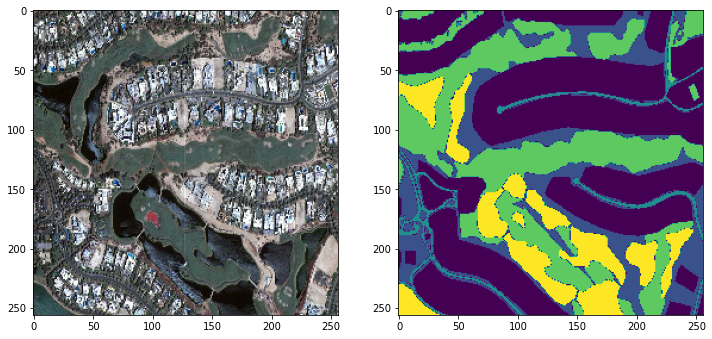

In [79]:
#Another Sanity check, view few mages
import random
import numpy as np
import matplotlib.pyplot as plt
image_number = random.randint(0, len(imagedata))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(imagedata[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [80]:
#one hot encoding to_categorical

n_classes = len(np.unique(labels))
from tensorflow.keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

##for the proper way to importing segmentation models we need the import Keras also
!pip install segmentation-models==1.0.1
import keras
from keras.utils import generic_utils
import segmentation_models as sm

#splitting data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imagedata, labels_cat, test_size = 0.20)

#those weights are optional, (automatically will be set all weights to 1)

weights = [0.155, 0.155, 0.155, 0.155, 0.155, 0.155]


#Creating a criterion to measure Dice loss class_weights – Array (np.array) of class weights (len(weights) = num_classes).
#for details check: https://github.com/qubvel/segmentation_models
dice_loss=sm.losses.DiceLoss(class_weights=weights)
focal=sm.losses.CategoricalFocalLoss()
total=dice_loss+(1*focal)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [81]:
y_train[0,:].shape

(256, 256, 6)

In [82]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, \
    Dropout, Lambda
from keras import backend as K

# jacard_coef for loss:  https://github.com/ZFTurbo/ZF_UNET_224_Pretrained_Model/blob/master/zf_unet_224_model.py
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

# architecture : https://github.com/zhixuhao/unet/blob/master/model.py
# https://github.com/bnsreenu/python_for_microscopists/blob/master/228_semantic_segmentation_of_aerial_imagery_using_unet/simple_multi_unet_model.py
def unet(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
    # Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    # define input layer
    s = inputs

    # begin with contraction part
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    # define output layer
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])


    return model


In [83]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]



metrics=['accuracy', jacard_coef]

def get_model():
    return unet(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=total, metrics=metrics)
model.summary()


history1 = model.fit(X_train, y_train,
                    batch_size =16,
                    verbose=1,
                    epochs=300,
                    validation_data=(X_test, y_test),
                    shuffle=False)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_76 (Conv2D)             (None, 256, 256, 16  448         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_36 (Dropout)           (None, 256, 256, 16  0           ['conv2d_76[0][0]']              
                                )                                                           

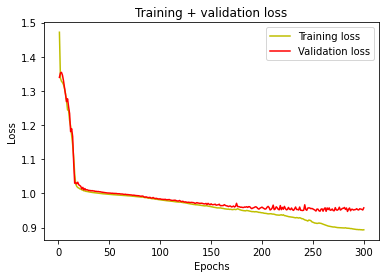

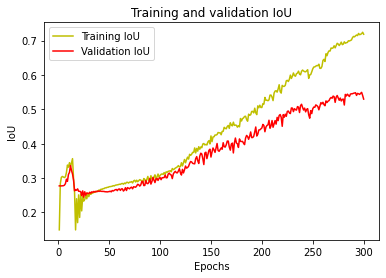

In [84]:
from matplotlib import pyplot as plt
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss') 
plt.title('Training + validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')  
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

# I would like to thank Dr. Sreenivas Bhattiprolu for giving me so much inspiration for this analysis, I tried to apply what I learned from his channel to this notebook. check his wonderful youtube channel:  https://www.youtube.com/channel/UC34rW-HtPJulxr5wp2Xa04w

In [101]:
model.save('semantic_segmentation_2.h5')

##Prediction

In [86]:
img=cv2.imread('/content/Semantic segmentation dataset/Tile 1/images/image_part_001.jpg',1)
img=cv2.resize(img,(256,256))
img=np.array(img)
# x= np.asarray(img)


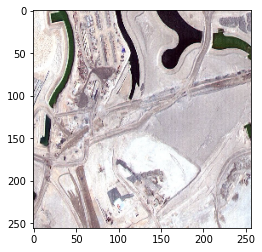

In [87]:
plt.imshow(img)

In [88]:
img.shape

(256, 256, 3)

In [89]:
X_train.shape

(57, 256, 256, 3)

In [90]:
final_image = np.expand_dims(img, axis=0) # To make the shape as (1, 2566, 256)
final_image = np.expand_dims(final_image, axis=-1) # To make the shape as (1, 2566, 256, 1)
# should work if you replace these two lines with your the code:
# final_image = np.reshape(final_image, (1, final_image.shape[0], final_image.shape[1],1))
# the expand_dims method is used to do the task generally, so I recommend you to use this.

In [91]:
Aliaa= model.predict(final_image)

1/1 [==============================] - 0s 234ms/step


In [92]:
Aliaa.shape

(1, 256, 256, 6)

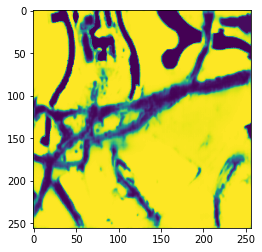

In [93]:
imgplot = plt.imshow(Aliaa[0,:,:,1])
plt.show()


In [94]:
import tensorflow as tf

In [95]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    return pred_mask

In [96]:
y_mask = create_mask(Aliaa)

In [97]:
def show_images(images, masks, nx=2, ny=4, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    plt.axis("off")

    for i in range(0, nx*ny):
        if i < nx*ny // 2:
            ax = plt.subplot(nx, ny, i+1)
            plt.imshow(images[i])
        else:
            ax = plt.subplot(nx, ny, i+1)
            plt.imshow(masks[i-nx*ny//2])

In [98]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

1/1 [==============================] - 0s 243ms/step


In [99]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
 
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 0s 17ms/step


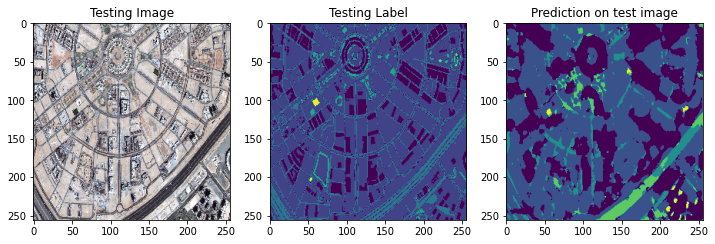

In [100]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()